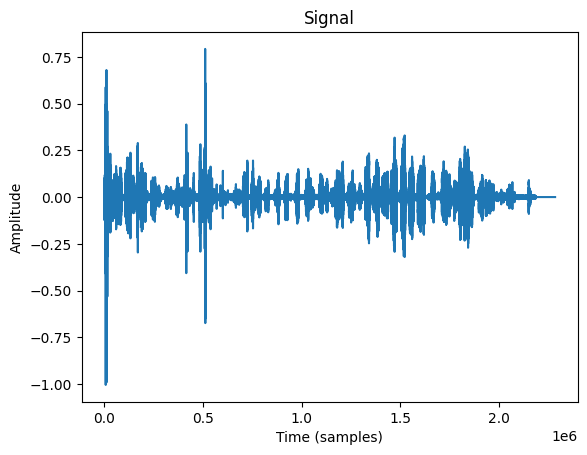

In [145]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

y, sr = librosa.load('-sTnP0BeOS4_30.wav')

plt.plot(y);
plt.title('Signal');
plt.xlabel('Time (samples)');
plt.ylabel('Amplitude');

In [146]:
import pandas as pd
import numpy as np

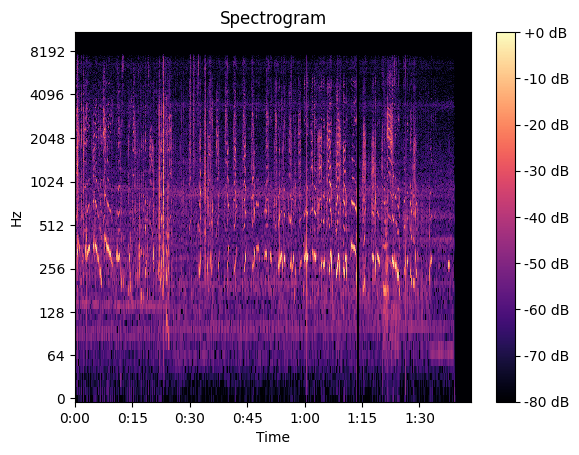

In [147]:
spec = np.abs(librosa.stft(y, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');

In [148]:
# 관련 라이브러리 가져오기
import matplotlib.pyplot as plt

import os
from glob import glob
import pandas as pd
import numpy as np
from PIL import Image
import random
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [149]:
# glob: 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
base_dir = './audioset-processing-master/output/meow'
train_folder = glob(base_dir)

train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp

In [150]:
train_path

['./audioset-processing-master/output/meow\\-b3inaM8l70_20.wav',
 './audioset-processing-master/output/meow\\-eqghuU6FRw_11.wav',
 './audioset-processing-master/output/meow\\-hbIQRl_Z58_30.wav',
 './audioset-processing-master/output/meow\\-r9CUTEa8wM_30.wav',
 './audioset-processing-master/output/meow\\-ttKN5Ba368_30.wav',
 './audioset-processing-master/output/meow\\-YpovYcGB4I_12.wav',
 './audioset-processing-master/output/meow\\06seVx9COw8_3.wav',
 './audioset-processing-master/output/meow\\07_DscDjfI8_3.wav',
 './audioset-processing-master/output/meow\\0BX5PY3LVTQ_25.wav',
 './audioset-processing-master/output/meow\\0DtJdRFPmS4_30.wav',
 './audioset-processing-master/output/meow\\0ES5i4nwdGk_0.wav',
 './audioset-processing-master/output/meow\\0GPOuYwbghw_30.wav',
 './audioset-processing-master/output/meow\\0GzDmD6HeF8_20.wav',
 './audioset-processing-master/output/meow\\1A_NgC9c1Cc_4.wav',
 './audioset-processing-master/output/meow\\1bMlH-Hi3OA_15.wav',
 './audioset-processing-maste

./audioset-processing-master/output/meow\0DtJdRFPmS4_30.wav


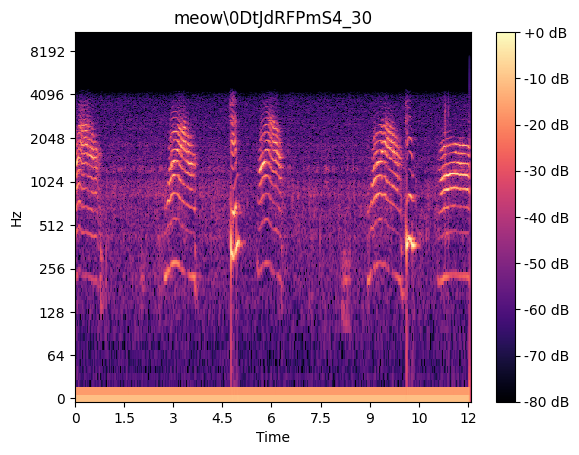

In [151]:
i=9
y, sr = librosa.load(train_path[i])
print(train_path[i])
spec = np.abs(librosa.stft(y, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec[:,:600], sr=sr, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title(train_path[i].split('/')[-1].split('.')[0]);

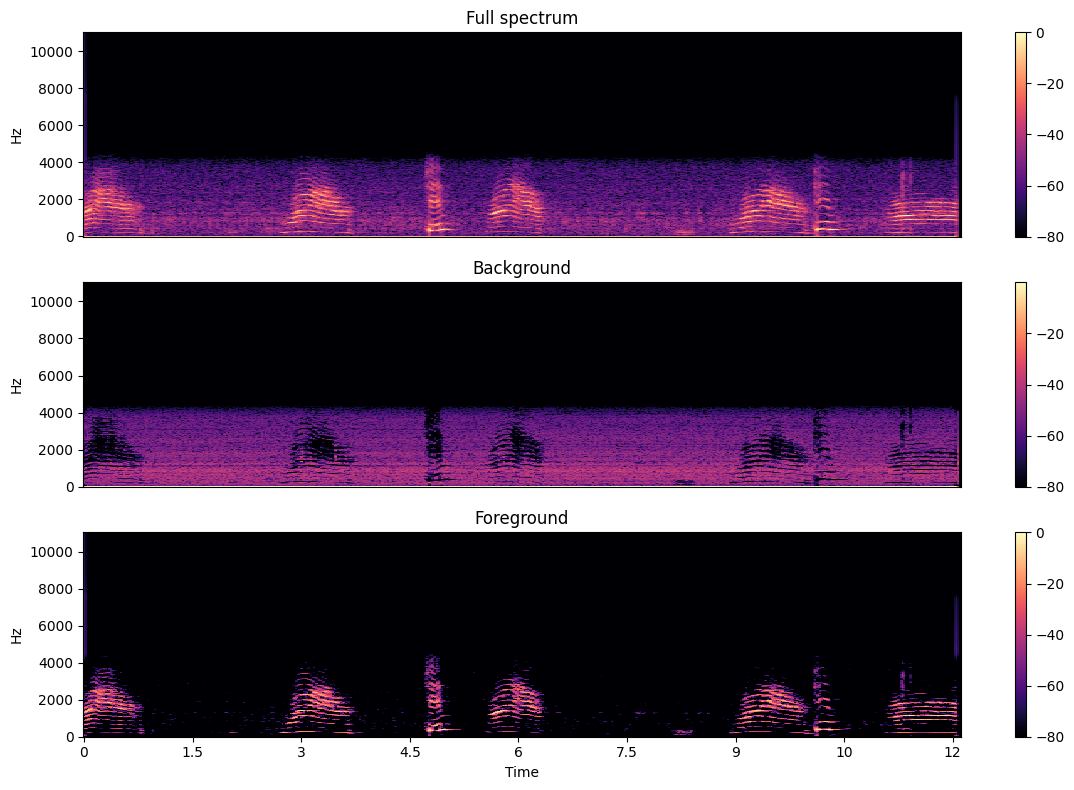

In [152]:

S_full, phase = librosa.magphase(librosa.stft(y)) #speech processing에 n_fft=512 권장된다고는함



# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimium
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components
S_foreground = mask_v * S_full
S_background = mask_i * S_full
# sphinx_gallery_thumbnail_number = 2

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full, ref=np.max),
                         y_axis='hz', sr=sr)
plt.title('Full spectrum')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_background, ref=np.max),
                         y_axis='hz', sr=sr)
plt.title('Background')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_foreground, ref=np.max),
                         y_axis='hz', x_axis='time', sr=sr)
plt.title('Foreground')
plt.colorbar()
plt.tight_layout()
plt.show()

In [153]:
y.shape

(266757,)

In [154]:
S_foreground.shape

(1025, 522)

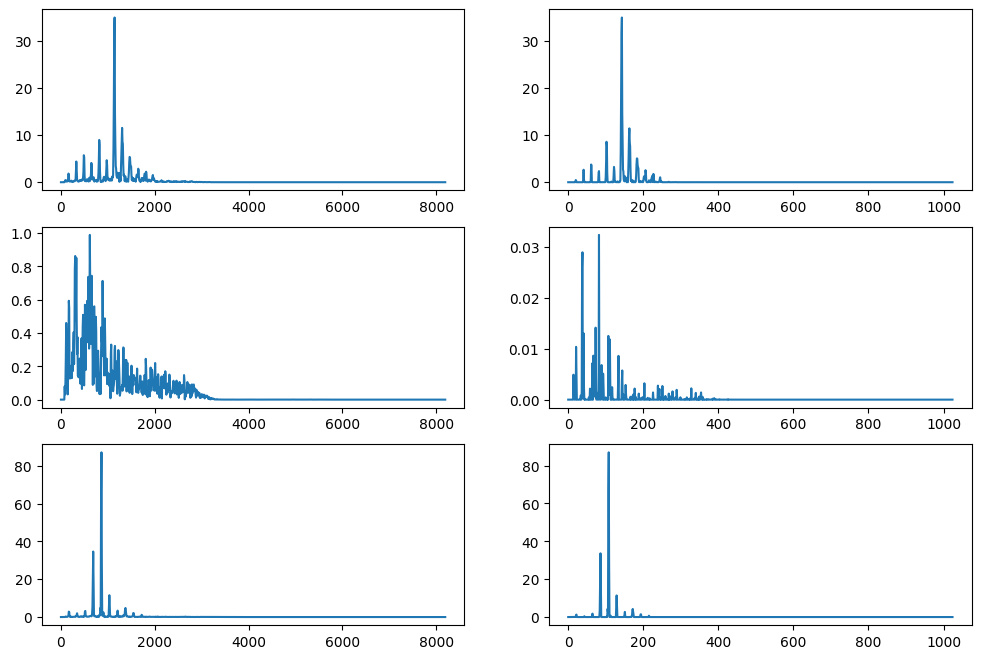

In [155]:
FREQ_MIN = 10

def get_timeslice(t, with_noise = False):
    S_arr=S_full if with_noise else S_foreground
    tslice=S_arr[:,librosa.time_to_frames(t,sr=sr)] #0보다 약간 큰 쪽에 피크 있음 -> 제거
    tslice[:FREQ_MIN] = 0
    return tslice
tlst = [0.5, 1.5, 11.5]
plt.figure(figsize=(12,8))
for i in range(len(tlst)):
    t=tlst[i]
    plt.subplot(len(tlst),2,1+i*2)
    plt.plot(np.linspace(0, 8192, 1025),get_timeslice(t, True))
    plt.subplot(len(tlst),2,2+i*2)
    plt.plot(get_timeslice(t, False))

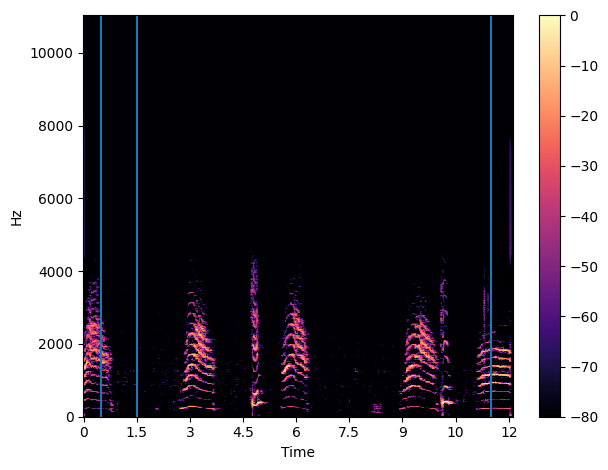

In [156]:
librosa.display.specshow(librosa.amplitude_to_db(S_foreground, ref=np.max),
                         y_axis='hz', x_axis='time', sr=sr)
for t in tlst:
    plt.axvline(x=t)
plt.colorbar()
plt.tight_layout()
plt.show()

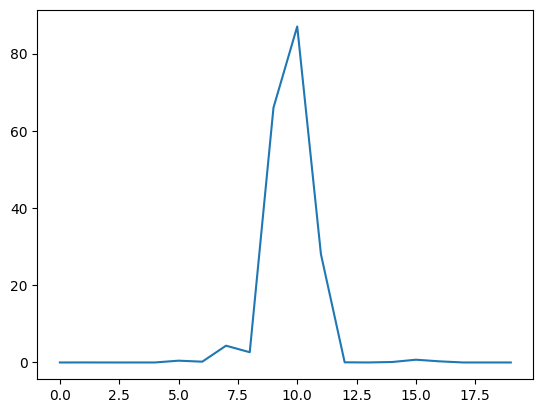

In [193]:
tslice=get_timeslice(11.5)
idx=np.argmax(tslice)
delta = 10
plt.plot(tslice[idx-delta:idx+delta])

In [158]:
'''
sr은 sampling rate -> time & 열 인덱스 관계 결정, frequncy & 행 인덱스 관계 결정

피크를 찾기 위해 필요한 거
1. 최소 Threshold. 적어도 1 넘는 애들끼리는 따져야 하지 않을까
2. 노이즈 제거 ->  Threshold 잡으면 사실 크게 필요할꺼같진 않음. 
'''

'\nsr은 sampling rate -> time & 열 인덱스 관계 결정, frequncy & 행 인덱스 관계 결정\n\n피크를 찾기 위해 필요한 거\n1. 최소 Threshold. 적어도 1 넘는 애들끼리는 따져야 하지 않을까\n2. 노이즈 제거 ->  Threshold 잡으면 사실 크게 필요할꺼같진 않음. \n'

In [159]:
tslice

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.2020155e-09,
       1.5652633e-08, 8.6292069e-08], dtype=float32)

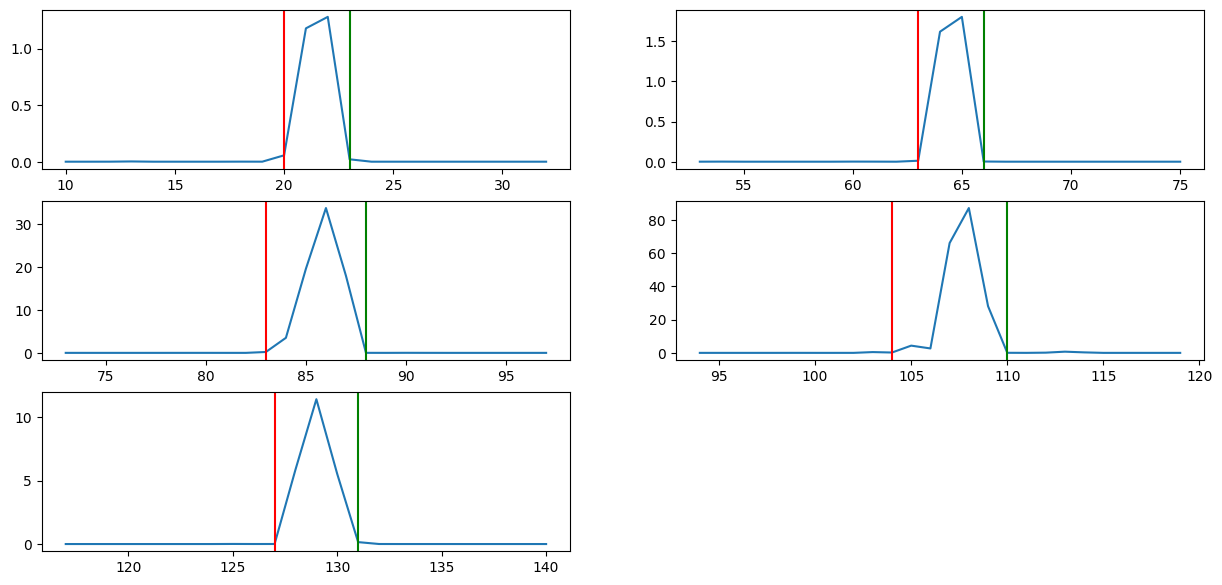

In [198]:
'''
전략: Threshold보다 작았다가 커지는거 탐지 & 커졌다가 작아지는거 탐지 -> 피크의 시작/끝 탐지해보자
numpy 함수들로 구현하는게 관건
'''
THRESHOLD = 1
PEAK_MAX_NUM = 5

def find_peaks(arr : np.ndarray):
    diff=np.diff(np.sign(arr-THRESHOLD))
    rising = np.where(diff==2)[0]
    rising = np.concatenate([rising, np.zeros(shape=(PEAK_MAX_NUM,))])[:PEAK_MAX_NUM]

    falling = np.where(diff==-2)[0]+1
    falling = np.concatenate([falling, np.zeros(shape=(PEAK_MAX_NUM,))])[:PEAK_MAX_NUM]

    return np.vstack([rising, falling])

tslice=get_timeslice(11.5)
peakarr = find_peaks(tslice).astype(int)

plt.figure(figsize=(15,12))
for i in range(peakarr.shape[1]):
    r,f = tuple(peakarr[:,i])
    if r==0:
        continue
    delta = 10
    plt.subplot(5,2,i+1)
    plt.plot(np.arange(r-delta,f+delta), tslice[r-delta:f+delta])
    plt.axvline(x=r, c='r')
    plt.axvline(x=f, c='g')
    

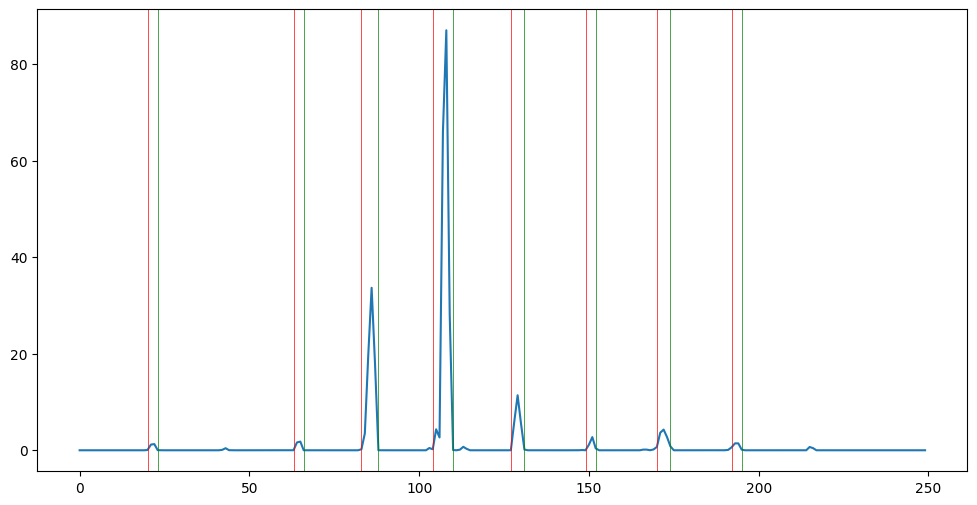

In [161]:
plt.figure(figsize=(12,6))
plt.plot(tslice[:250])

for i in range(peakarr.shape[1]):
    r,f = tuple(peakarr[:,i])
    if r==0:
        continue
    plt.axvline(x=r, c='r', linewidth=0.5)
    plt.axvline(x=f, c='g', linewidth=0.5)


In [162]:
'''
피크에 대해 필요한 정보?
1) 위치
2) 너비? (이건 큰 의미 없을 듯. ㅊㅍ frequency 간격이 너무 넓어서)
3) 높이 
--> 위치와 높이만 필요
'''

'\n피크에 대해 필요한 정보?\n1) 위치\n2) 너비? (이건 큰 의미 없을 듯. ㅊㅍ frequency 간격이 너무 넓어서)\n3) 높이 \n--> 위치와 높이만 필요\n'

In [163]:
print(sr)

22050


In [164]:
S_full.shape

(1025, 522)

In [200]:
def ctft_to_peaks(carr : np.ndarray, threshold = 1, max_peak_num = 10):
    rising = np.zeros(shape=(max_peak_num, carr.shape[1]))
    falling = np.zeros(shape=(max_peak_num , carr.shape[1]))
    diff=np.diff(np.sign(carr.T-threshold), axis = 1)

    for arr, num in [(rising, 2), (falling, -2)]:
        a,b = np.where(diff==num)
        for i in range(diff.shape[0]):
            temp=b[a==i]
            minlen = min(max_peak_num, len(temp))
            arr[:minlen,i]=temp[:minlen]

    return (rising, falling)

In [216]:
from scipy.signal import convolve2d
S_smoothed = convolve2d(S_foreground, np.ones(3).reshape((1,-1))/5)

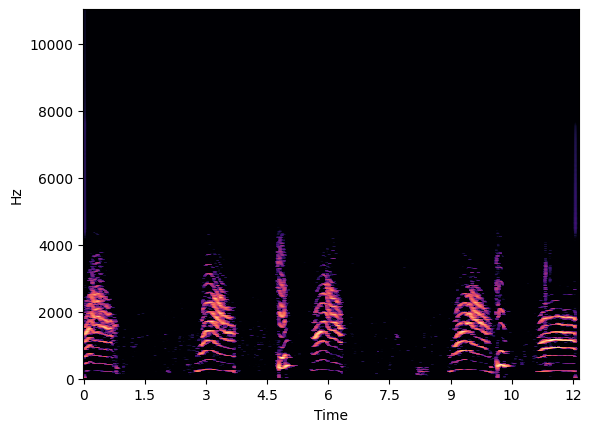

In [217]:
librosa.display.specshow(librosa.amplitude_to_db(S_smoothed, ref=np.max),
                         y_axis='hz', x_axis='time', sr=sr)

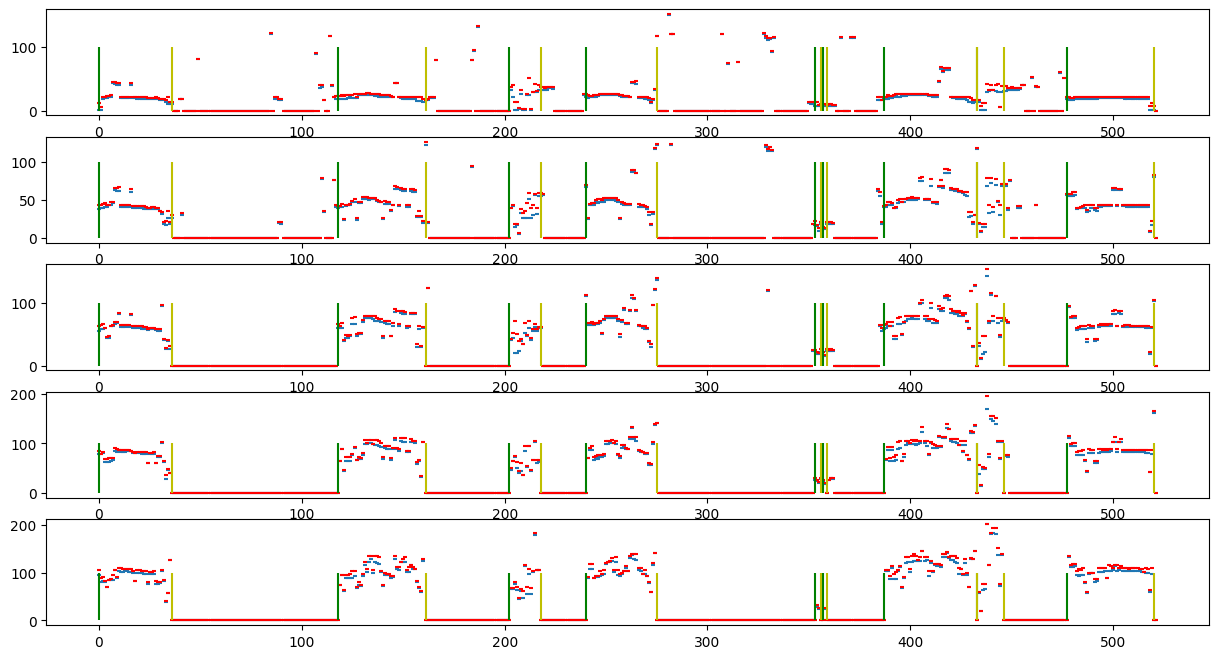

In [271]:
rising, falling = ctft_to_peaks(S_foreground, threshold=0.1, max_peak_num=5)

x=np.arange(0, rising.shape[1],1/1).astype(int)
plt.figure(figsize=(15,8))

#의미있는 부분만 잘라내기
cnt_mat = (rising > 1e-5).sum(axis=0)
thres = 5 - 0.5
cutpoint_rising = np.where(np.diff(np.sign(cnt_mat-thres))==2)[0]
cutpoint_falling = np.where(np.diff(np.sign(cnt_mat-thres))==-2)[0]+1
if(cnt_mat[0] > thres):
    cutpoint_rising = np.insert(0,0,cutpoint_rising)

for i in range(5):
    rising_2 = rising[i,:]
    falling_2 = falling[i,:]
    plt.subplot(5,1,i+1)
    plt.scatter(x[:], rising_2[:], s=10, marker='_')
    plt.scatter(x[:], falling_2[:], s=10, marker='_', c='r')
    plt.vlines(x=cutpoint_rising, ymin=0, ymax= 100,color='g')
    plt.vlines(x=cutpoint_falling, ymin=0, ymax= 100,color='y')

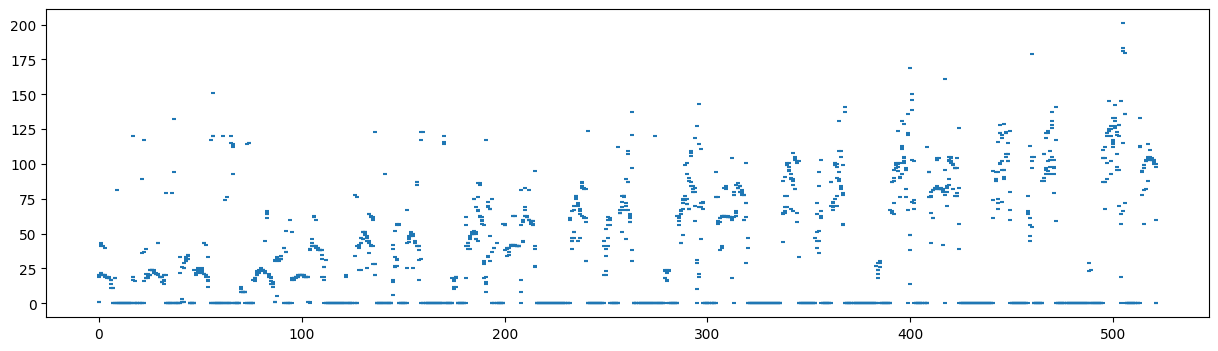

In [252]:
x=np.arange(0, rising.shape[1],0.2).astype(int)
plt.figure(figsize=(15,4))
plt.scatter(x, rising.flatten(), s=10, marker='_')